In [1]:
import os
path = 'F:\Python Directory\Diageo Case Data'
os.chdir(path)

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)
import seaborn as sns
sns.set(style="whitegrid")
from functools import reduce
import warnings
warnings.filterwarnings('ignore')


inv_data = pd.read_csv('InvoiceData.csv')
disp_data = pd.read_csv('Disputes.csv')

dispute_docs = ['YVCR', 'YVDR','YCR','YDR'] 
disp_data = disp_data[disp_data['PO_Type'].isin(dispute_docs)]
print(inv_data.shape)
print(disp_data.shape)

(420554, 9)
(40414, 9)


In [3]:
#number of PO under dispute by customer ID
df_dispute = disp_data.groupby('Customer_ID')['Country_ID'].count().to_frame().reset_index()
df_dispute = df_dispute.rename(columns = {'Country_ID':'cnt_dispute_PO'})
#amount of PO under dispute by customer ID
df_dispute_amt = disp_data.groupby('Customer_ID')['PO_Amount'].mean().reset_index()
df_dispute_amt = df_dispute_amt.rename(columns = {'PO_Amount':'dispute_PO_amt'})

### Background

Data belongs to invoices created over a certain time period by Random Ltd, a CPG company for the goods sold to retailers/distributors. These retailers/distributors are supposed to pay against these invoices as per defined payment terms of the company. Recently Random Ltd. has realised that some of these reatilers/distributors are not honoring the payment terms and are delaying or not paying their payments leading to problems in their cashflow.

In this analysis, I have been provided with 2 datasets: 1st dataset consists of more than 400K+ invoices and payment history belongs to 1037 customers. Another file is shared with purchase order details and PO's under dispute.

Here our aim is to understand customer behavior regarding invoice payments, and propose an analytical approach to learning and predicting payment behavior. The logic can then be embedded into a decision support system where decision makers can make predictions regarding future payments, and take actions as necessary toward the collection of potentially unpaid debt, or adjust their financial plans based on the expected invoice-to-cash amount.

##### Data Pre-processing

In [4]:
#converting string date formats to datetime
date_cols = ['Invoice_Creation_Date','Invoice_Due_Date','Invoice_Clearing_date']
date_cols1 = ['PO_Created_Date','PO_Modified_Date','PO_Delivery_Date']

for i in date_cols:
    inv_data[i] = inv_data[i].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'))

for i in date_cols1:
    disp_data[i] = disp_data[i].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'))

In [5]:
#calculate difference in days between due date and claering date
inv_data['invoice_due_in_days'] = (inv_data['Invoice_Due_Date'] - inv_data['Invoice_Creation_Date']).dt.days
#how many days invoice paid in
inv_data['invoice_paid_in_days'] = np.where(inv_data['Invoice_Clearing_date'] != '1900-01-01',
                                            (inv_data['Invoice_Clearing_date'] - inv_data['Invoice_Creation_Date']).dt.days,
                                           inv_data['invoice_due_in_days'])
#how many days later invoice got paid if paid after due date
inv_data['delay_in_days'] = np.where((inv_data['invoice_paid_in_days']-inv_data['invoice_due_in_days'])>0,
                                    (inv_data['invoice_paid_in_days']-inv_data['invoice_due_in_days']),0)
#merging information from PO dispute like number of PO under dispute and amount of dispute by customer ID
inv_data = pd.merge(inv_data, df_dispute,how = 'left', on = ['Customer_ID'])
inv_data = pd.merge(inv_data, df_dispute_amt,how = 'left', on = ['Customer_ID'])

In [6]:
#assigning paid status against each invoice
inv_data['paid_status'] = np.where(inv_data['invoice_due_in_days'] >= inv_data['invoice_paid_in_days'],'invoice_paid_in_time',
                                  np.where((inv_data['invoice_due_in_days'] < inv_data['invoice_paid_in_days']) &
                                          (inv_data['Invoice_Due_Date'].dt.month == inv_data['Invoice_Clearing_date'].dt.month),
                                          'invoice_paid_in_same_month','invoice_paid_over_month_or_not_paid'))

#putting unpaid invoices under 'invoice_paid_over_month_or_not_paid'
inv_data.loc[inv_data['Invoice_Clearing_date'] == '1900-01-01','paid_status'] = 'invoice_paid_over_month_or_not_paid'

In [7]:
inv_data.head()

,Invoice_Serial,Invoice_Billing_ID,Customer_ID,Fiscal_Period,Country_ID,Invoice_Creation_Date,Invoice_Due_Date,Invoice_Clearing_date,Invoice_amount,invoice_due_in_days,invoice_paid_in_days,delay_in_days,cnt_dispute_PO,dispute_PO_amt,paid_status
0,02016100044017629671201602,9012194789,10112,201602,77,2015-07-08,2015-08-21,2015-08-18,3644.57,44,41,0,3.0,1353.333333,invoice_paid_in_time
1,02015100044017516841201601,9012188108,10114,201601,77,2015-06-02,2015-07-21,2015-07-21,4927.61,49,49,0,27.0,977.556296,invoice_paid_in_time
2,02015100044017524651201601,9012188544,10114,201601,77,2015-06-04,2015-07-21,2015-07-21,10337.89,47,47,0,27.0,977.556296,invoice_paid_in_time
3,02015100044017522681201601,9012188470,10114,201601,77,2015-06-04,2015-07-21,2015-07-21,4223.66,47,47,0,27.0,977.556296,invoice_paid_in_time
4,02015100044017531121201601,9012188900,10114,201601,77,2015-06-08,2015-07-21,2015-07-21,1407.89,43,43,0,27.0,977.556296,invoice_paid_in_time


### Exploratory Data Analysis

Barplot showing percentage of invoices under each of the 3 payment status:

1. invoice_paid_in_time - 39.56% of the total invoices are paid within due date
2. invoice_paid_in same month - 45.37% of the invoices are paid in time above due date but within same month of due date
3. invoice_paid_later_not_paid - 15.07% of the invoices are not either not paid or paid in time above due date and in next month of due date month.

In [8]:
df_CF1 = inv_data[(inv_data['paid_status']== 'invoice_paid_in_time') & (inv_data['Fiscal_Period'] <= 201901)].groupby('Fiscal_Period')['Invoice_amount'].sum().reset_index()
df_CF1 = df_CF1.rename(columns = {'Invoice_amount':'invoice_paid_in_time'})
df_CF2 = inv_data[(inv_data['paid_status']== 'invoice_paid_in_same_month') & (inv_data['Fiscal_Period'] <= 201901)].groupby('Fiscal_Period')['Invoice_amount'].sum().reset_index()
df_CF2 = df_CF2.rename(columns = {'Invoice_amount':'invoice_paid_in_same_month'})
df_CF3 = inv_data[(inv_data['paid_status']== 'invoice_paid_over_month_or_not_paid') & (inv_data['Fiscal_Period'] <= 201901)].groupby('Fiscal_Period')['Invoice_amount'].sum().reset_index()
df_CF3 = df_CF3.rename(columns = {'Invoice_amount':'invoice_paid_over_month_or_not_paid'})
df_CF = pd.concat([df_CF1,df_CF2,df_CF3],1)
df_CF = df_CF[['Fiscal_Period','invoice_paid_in_time','invoice_paid_in_same_month',
                                            'invoice_paid_over_month_or_not_paid']]
df_CF = df_CF.iloc[:,2:]
df_CF['invoice_delayed_as_pct_in_time'] = df_CF['invoice_paid_over_month_or_not_paid']/df_CF['invoice_paid_in_time']
df_CF['invoice_delayed_as_pct_in_same_month'] = df_CF['invoice_paid_over_month_or_not_paid']/df_CF['invoice_paid_in_same_month']
df_CF['invoice_delayed_as_pct_portfolio'] = df_CF['invoice_paid_over_month_or_not_paid']/(df_CF['invoice_paid_in_time'] + df_CF['invoice_paid_in_same_month'] + df_CF['invoice_paid_over_month_or_not_paid'])
df_CF['invoice_paid_in _same_month_as_pct_portfolio'] = df_CF['invoice_paid_in_same_month']/(df_CF['invoice_paid_in_time'] + df_CF['invoice_paid_in_same_month'] + df_CF['invoice_paid_over_month_or_not_paid'])

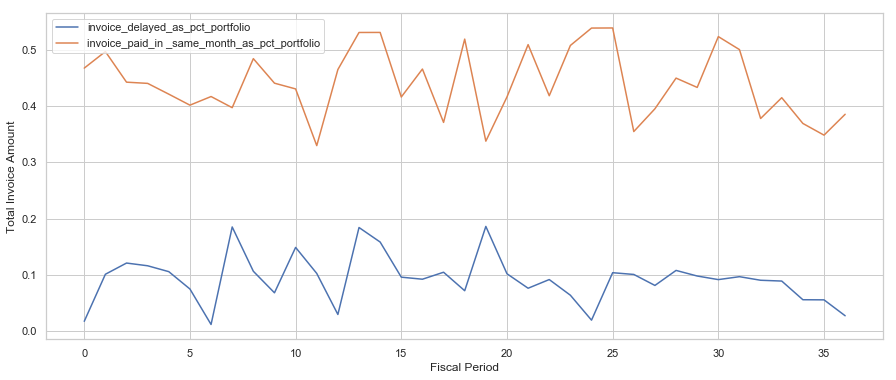

In [9]:
#visualizing invoice amount under 
df_CF[['invoice_delayed_as_pct_portfolio',
       'invoice_paid_in _same_month_as_pct_portfolio']].plot(kind = 'line',figsize = (15,6),
                                                    label = 'trendlines of invoice amount by fiscal period by payment status')
plt.ylabel('Total Invoice Amount')
plt.xlabel('Fiscal Period')
plt.legend(loc = 'upper left')

In [10]:
print(df_CF['invoice_delayed_as_pct_in_time'].mean())
print(df_CF['invoice_delayed_as_pct_in_same_month'].mean())
print(df_CF['invoice_delayed_as_pct_portfolio'].std())
print(df_CF['invoice_paid_in _same_month_as_pct_portfolio'].std())

0.21394273430093463
0.21586247331890457
0.043097139432988554
0.060811963624370954


In [11]:
inv_data['paid_status'].value_counts()

invoice_paid_in_same_month             190803
invoice_paid_in_time                   166351
invoice_paid_over_month_or_not_paid     63400
Name: paid_status, dtype: int64

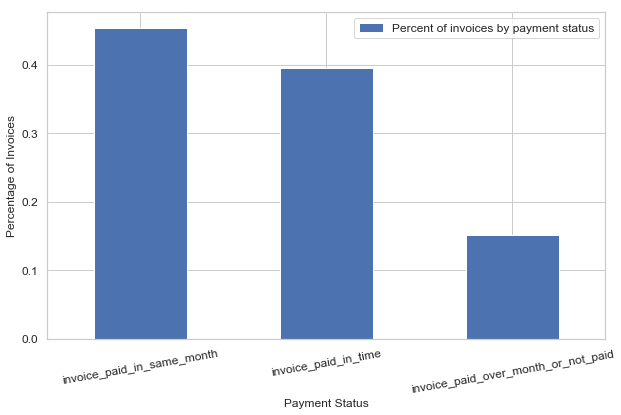

In [12]:
#percentage of invoices under each payment status
inv_data['paid_status'].value_counts(normalize = True).plot(kind='bar', figsize=(10,6), 
                                                            label = 'Percent of invoices by payment status')
plt.xticks(rotation = 10)
plt.legend(loc="upper right", fontsize = 'large')
plt.xlabel('Payment Status', fontsize = 'large')
plt.ylabel('Percentage of Invoices', fontsize = 'large')
plt.xticks(fontsize = 'large')
plt.yticks(fontsize = 'large')
plt.show()

Below plot is showing breakup of invoice payment status by country

* Country with ID 83 is having 47% of total invoices which either got delayed over month or not paid having a pronounced negative effect on cashflow
* Country with ID 77 is having 51% of total invoices which are paid within due date and having a positive effect on cashflow

This clearly shows that countries do have effect on payment behaviour of retailer/distributors and could be used as a good feature in modelling 

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 <a list of 7 Text yticklabel objects>)

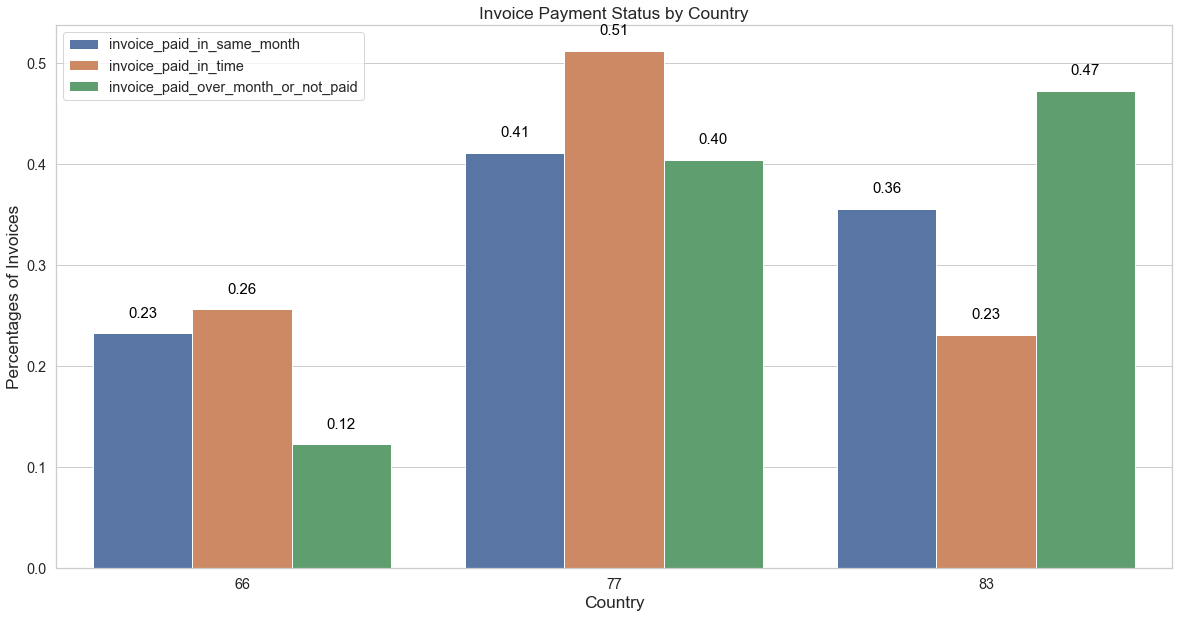

In [13]:
#invoice payment status vs country
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams["axes.labelsize"] = 12
x, y, hue = "Country_ID", "proportion", "paid_status"

df = inv_data[x].groupby(inv_data[hue]).value_counts(normalize=True).rename(y).reset_index()
g=sns.barplot(x=x, y=y, hue = hue, data=df)
ax = g
for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=15, color='black', xytext=(0, 20),
                 textcoords='offset points')
plt.title('Invoice Payment Status by Country', fontsize = 'xx-large')
plt.xlabel('Country', fontsize = 'xx-large')
plt.ylabel('Percentages of Invoices', fontsize = 'xx-large')
plt.legend(fontsize = 'x-large')
plt.xticks(fontsize = 'x-large')
plt.yticks(fontsize = 'x-large')

In [14]:
#breakup of invoices by countries 
inv_data.groupby('Country_ID')['Country_ID'].count()/inv_data['Country_ID'].count()

Country_ID
66    0.225503
77    0.450292
83    0.324206
Name: Country_ID, dtype: float64

##### EDA based on invoice due days (number of days a customer is given to clear invoice)

Here the hypothesis was that invoices with larger difference between due date and invoice creation date (number of days) tend to be paid within time or in same month and invoices with smaller difference tend to be delayed over month.

Below barchart shows average difference between invoice generation date and invoice due date (number of days allowed for customer to pay their invoice amount).

This chart clearly shows that customers who paid their invoices within due date or within same month are having much higher average number of days (42 days) than customer who paid invoice over month or not paid at all (31 days).

This clearly shows that customers provided with larger due time to clear their invoices are more likely to clear it within due time.

Based on this observation, we can use 'invoice_due_in_days' as a feature in model development

In [15]:
#average number of due days available to customer for paying their invoices by payment status corrected for unpaid invoices
inv_data.groupby(inv_data['paid_status'])['invoice_due_in_days'].mean()

paid_status
invoice_paid_in_same_month             42.721320
invoice_paid_in_time                   41.983156
invoice_paid_over_month_or_not_paid    33.334921
Name: invoice_due_in_days, dtype: float64

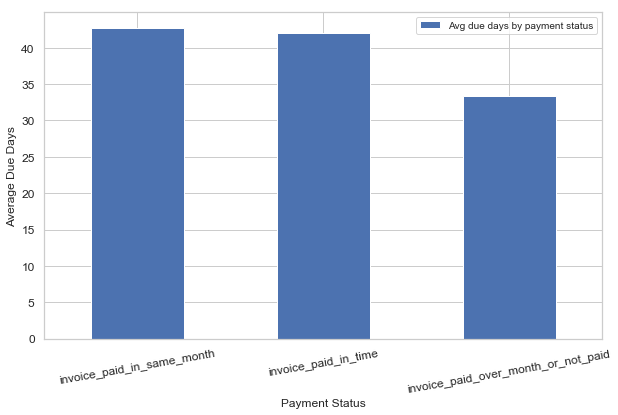

In [16]:
inv_data.groupby(inv_data['paid_status'])['invoice_due_in_days'].mean().plot(kind='bar', figsize=(10,6), 
                                                            label = 'Avg due days by payment status')
plt.xticks(rotation = 10)
plt.legend(loc="upper right", fontsize = 'medium')
plt.xlabel('Payment Status', fontsize = 'large')
plt.ylabel('Average Due Days', fontsize = 'large')
plt.xticks(fontsize = 'large')
plt.yticks(fontsize = 'large')
plt.show()

Below barchart is further to investigate invoice due in days by payment status and country to see if the above observation hold true for all 3 countries or not.

For country with ID 83, we see that average invoice due days for invoice paid in time is similar to invoice paid over month. In other 2 countries, the above observation holds true (average invoice due days is higher for invoices paid in time and paid in same month than for invoices paid over month or not paid)

In [17]:
#breakup of average due days available to customers for paying invoices by payment status across countries
pd.DataFrame(inv_data.groupby(['Country_ID','paid_status'])['invoice_due_in_days'].mean().reset_index())

,Country_ID,paid_status,invoice_due_in_days
0,66,invoice_paid_in_same_month,55.069418
1,66,invoice_paid_in_time,53.910950
2,66,invoice_paid_over_month_or_not_paid,40.316769
3,77,invoice_paid_in_same_month,38.164432
4,77,invoice_paid_in_time,42.284617
5,77,invoice_paid_over_month_or_not_paid,34.765429
6,83,invoice_paid_in_same_month,39.915088
7,83,invoice_paid_in_time,28.079997
8,83,invoice_paid_over_month_or_not_paid,30.297885


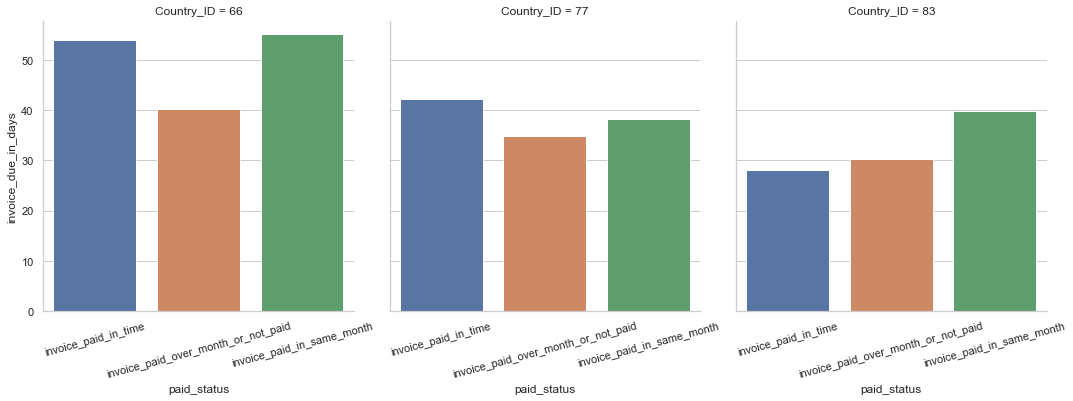

In [18]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams["axes.labelsize"] = 12

chart = sns.catplot('paid_status', 'invoice_due_in_days', col="Country_ID", col_wrap=3,ci = None,
                data=inv_data,
                kind='bar')
chart.set_xticklabels(rotation=15)

The initial hypothesis holds true!

##### EDA based on Invoice amount

Here the assumption is that invoices with larger amount tend to be paid within due days as compared to invoices with smaller amount. This is because large amount invoices is created for large size retailers/distributors having a good financial health and are less likely to delay invoice clearance.

In [19]:
print(inv_data['Invoice_amount'].min())
print(inv_data['Invoice_amount'].max())
print(inv_data['Invoice_amount'].mean())
print(inv_data['Invoice_amount'].median())

0.00011970299999999999
6806901.92
29039.918176764582
7935.959041


In [20]:
inv_data['Invoice_amount'].describe()

count    4.205540e+05
mean     2.903992e+04
std      6.408366e+04
min      1.197030e-04
25%      1.199991e+03
50%      7.935959e+03
75%      3.063533e+04
max      6.806902e+06
Name: Invoice_amount, dtype: float64

Box plot is created using log of invoice amount against payment status and country. It is shwoing distribution of invoices on log scale and here we can see are lot of outliers in invoice amount (very large or very small amounts). This is clear from the above summary that invoice amount distribution is having a large range (min: 0.00012 to max: 6806901)

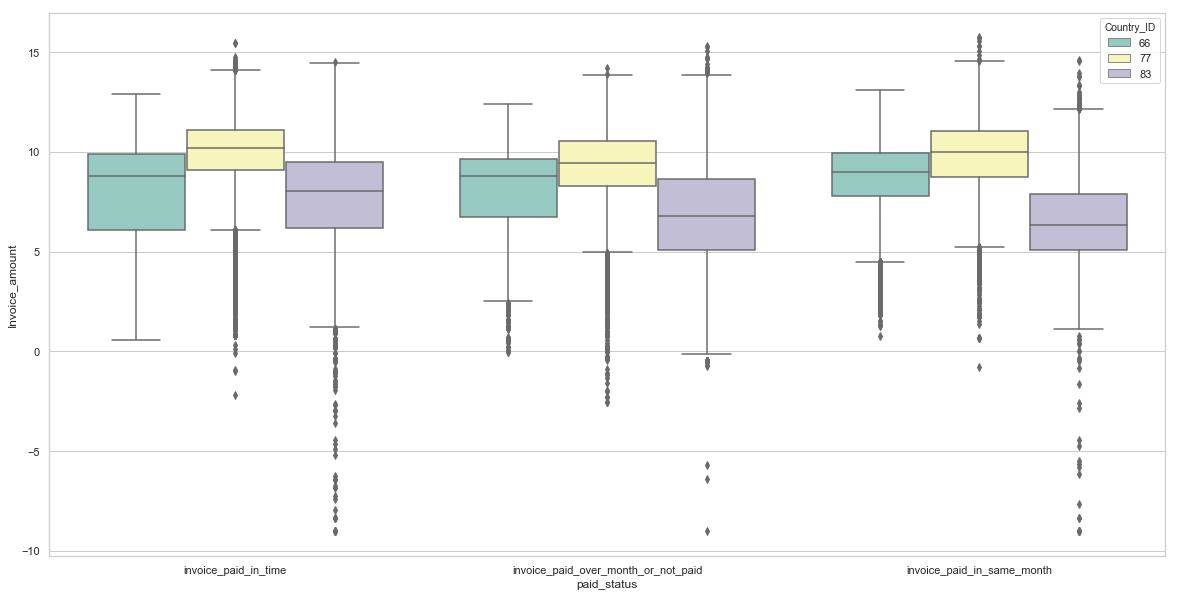

In [21]:
#distibution of invoice amount by paid status
plt.rcParams['figure.figsize'] = (20, 10)
ax = sns.boxplot(x=inv_data['paid_status'], y=np.log(inv_data['Invoice_amount']), hue=inv_data['Country_ID'], 
                 palette="Set3")

Below barchart shows that invoices with low amount are more likely to get delayed while invoices with large amount are more likely to get paid within due date. 

In [22]:
#average invoice amount by payment status
print('Average invoice amount by payment status: {}'
      .format(round(inv_data.groupby(inv_data['paid_status'])['Invoice_amount'].mean())))

Average invoice amount by payment status: paid_status
invoice_paid_in_same_month             26933.0
invoice_paid_in_time                   34732.0
invoice_paid_over_month_or_not_paid    20447.0
Name: Invoice_amount, dtype: float64


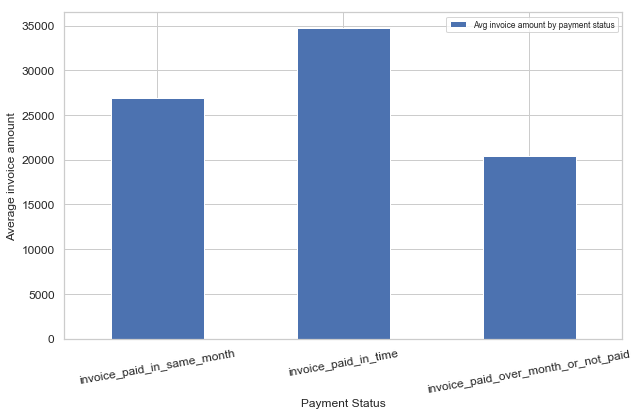

In [23]:
#Average invoice amount by paid status
inv_data.groupby(inv_data['paid_status'])['Invoice_amount'].mean().plot(kind='bar', figsize=(10,6), 
                                                            label = 'Avg invoice amount by payment status')

plt.xticks(rotation = 10)
plt.legend(loc="upper right", fontsize = 'small')
plt.xlabel('Payment Status', fontsize = 'large')
plt.ylabel('Average invoice amount', fontsize = 'large')
plt.xticks(fontsize = 'large')
plt.yticks(fontsize = 'large')
plt.show()

The boxplot above is not giving a clear relatioship between invoice amount with payment status and country. To further investigate, below barchart is created to see average invoice amount by payment status and country. Country with ID 77 is having much larger average invoice amount for invoices either paid later than due date or not paid at all (33231). So this country seems to have a more pronounced effect of delay in invoice payments on cashflow then other two countries.

In [24]:
#average invoice amount by payment status across countries
pd.DataFrame(inv_data.groupby(['Country_ID','paid_status'])['Invoice_amount'].mean().reset_index())

,Country_ID,paid_status,Invoice_amount
0,66,invoice_paid_in_same_month,20530.441868
1,66,invoice_paid_in_time,15763.221617
2,66,invoice_paid_over_month_or_not_paid,15142.120788
3,77,invoice_paid_in_same_month,48875.002442
4,77,invoice_paid_in_time,51938.695193
5,77,invoice_paid_over_month_or_not_paid,33231.325950
6,83,invoice_paid_in_same_month,5767.933468
7,83,invoice_paid_in_time,17612.563689
8,83,invoice_paid_over_month_or_not_paid,10892.392201


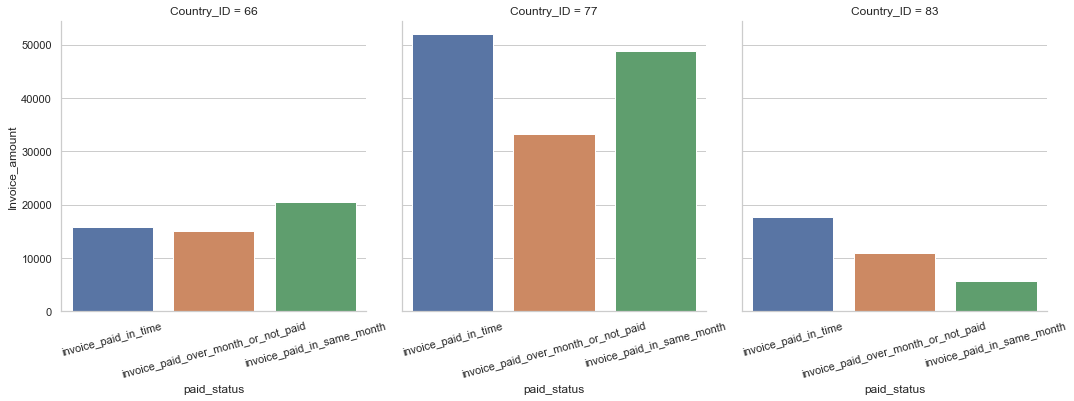

In [25]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams["axes.labelsize"] = 12
chart = sns.catplot("paid_status",'Invoice_amount', col="Country_ID", col_wrap=3,ci = None,
                data=inv_data,
                kind="bar")
chart.set_xticklabels(rotation=15)

##### EDA based on delay (delay in number of days made by customer in clearing invoice)

Below chart shows an average delay (number of days after due date) in paying invoices by country.

* Invoices paid within same month of due date tend be delayed on an average of 5 days across all 3 countries
* Invoices paid later than due date or within same month tend to be delayed between 35 to 43 days on an average. Country with ID 83 is having the largest average delay.

In [26]:
#average delay in payment in days by payment status across countries
pd.DataFrame(inv_data[inv_data['delay_in_days']>0].groupby(['Country_ID','paid_status'])['delay_in_days'].mean().reset_index())

,Country_ID,paid_status,delay_in_days
0,66,invoice_paid_in_same_month,4.838799
1,66,invoice_paid_over_month_or_not_paid,39.711129
2,77,invoice_paid_in_same_month,5.005976
3,77,invoice_paid_over_month_or_not_paid,35.265982
4,83,invoice_paid_in_same_month,5.603041
5,83,invoice_paid_over_month_or_not_paid,42.674984


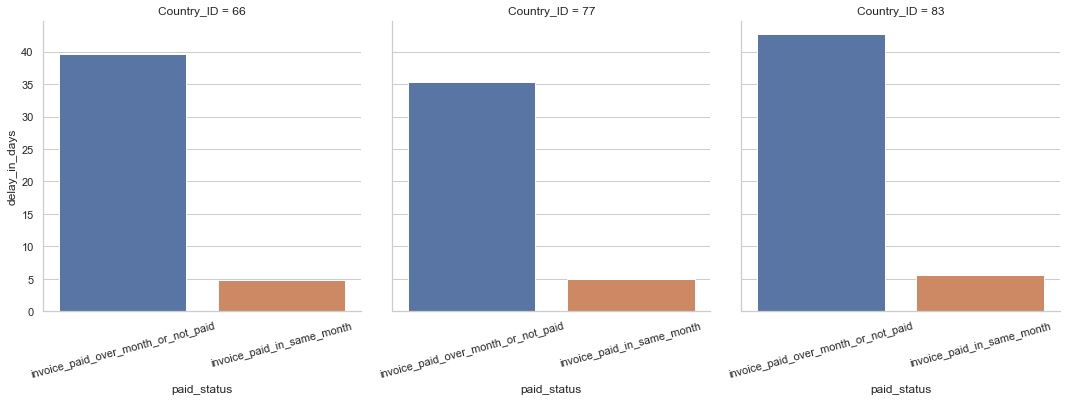

In [27]:
#Average delay in invoice delay in payment in days across country
inv_data1 = inv_data[inv_data['delay_in_days']>0]
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams["axes.labelsize"] = 12

chart = sns.catplot('paid_status', 'delay_in_days', col="Country_ID", col_wrap=3,
                data=inv_data1, ci = None,kind='bar')

chart.set_xticklabels(rotation=15)

##### EDA based on number of invoices per customer

Here assumption is that customer with fewer invoices are less likely to make late payment.

A purity index is calculated between 0 and 1 indicating proportion of invoices for which customer has delayed in payment over total number of invoices for the customer.

Total number of invoices against each customers are binned into several buckets: less than 10, between 10 to 25 and so on

In [28]:
df1 = pd.DataFrame(inv_data.loc[inv_data['paid_status'] == 'invoice_paid_in_time']
                   .groupby(inv_data['Customer_ID'])['paid_status'].count().reset_index())
df1 = df1.rename(columns = {'paid_status': 'cnt_invoice_paid_in_time'})
df2 = pd.DataFrame(inv_data.loc[inv_data['paid_status'] == 'invoice_paid_in_same_month']
                   .groupby(inv_data['Customer_ID'])['paid_status'].count().reset_index())
df2 = df2.rename(columns = {'paid_status': 'cnt_invoice_paid_in_same_month'})
df3 = pd.DataFrame(inv_data.loc[inv_data['paid_status'] == 'invoice_paid_over_month_or_not_paid']
                   .groupby(inv_data['Customer_ID'])['paid_status'].count().reset_index())
df3 = df3.rename(columns = {'paid_status': 'cnt_invoice_paid_over_month_or_not_paid'})

In [29]:
df_list = [df1,df2,df3]

final_df = reduce(lambda left,right: pd.merge(left,right,how = 'outer',on='Customer_ID'), df_list)
final_df.fillna(0, inplace=True)
final_df['num_invoice'] = final_df['cnt_invoice_paid_in_time']+final_df['cnt_invoice_paid_in_same_month']+final_df['cnt_invoice_paid_over_month_or_not_paid']

In [30]:
final_df['cnt_invoice'] = np.where(final_df['num_invoice'] < 10,'less than 10',
                                  np.where((final_df['num_invoice']>=10)&(final_df['num_invoice']<25),'between 10 and 25',
                                          np.where((final_df['num_invoice']>=25)&(final_df['num_invoice']<50),'between 25 and 50',
                                                  np.where((final_df['num_invoice']>=50)&(final_df['num_invoice']<100),'between 50 and 100',
                                                          np.where((final_df['num_invoice']>=100)&(final_df['num_invoice']<200),'between 100 and 200',
                                                                  'more than 200')))))
final_df['impurity_index1'] = (final_df['cnt_invoice_paid_over_month_or_not_paid']+final_df['cnt_invoice_paid_in_same_month'])/final_df['num_invoice']
final_df['impurity_index2'] = (final_df['cnt_invoice_paid_over_month_or_not_paid'])/final_df['num_invoice']

In [31]:
final_df.groupby('cnt_invoice')['impurity_index1'].mean().sort_values()

cnt_invoice
less than 10           0.305118
between 10 and 25      0.474184
between 100 and 200    0.536017
between 25 and 50      0.537213
more than 200          0.557146
between 50 and 100     0.587732
Name: impurity_index1, dtype: float64

In [32]:
final_df.groupby('cnt_invoice')['impurity_index2'].mean().sort_values()

cnt_invoice
between 100 and 200    0.111172
between 25 and 50      0.113748
between 10 and 25      0.134593
between 50 and 100     0.137861
more than 200          0.138874
less than 10           0.141824
Name: impurity_index2, dtype: float64

Below chart is clearly showing that customers with less number of invoices are less likely to delay payment and as the number of invoices increases, delay in making payments also increases.

The result below holds the assumption!

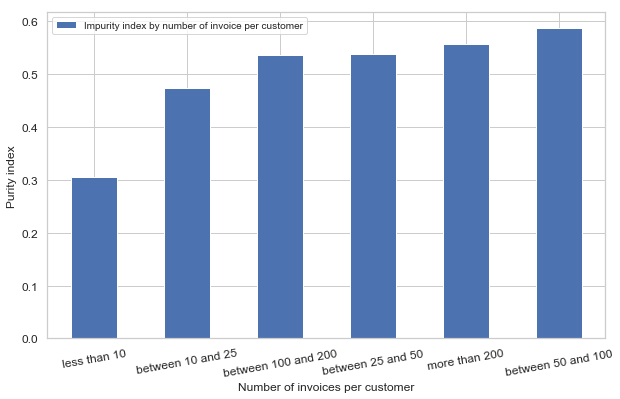

In [33]:
final_df.groupby('cnt_invoice')['impurity_index1'].mean().sort_values().plot(kind = 'bar',figsize=(10,6), 
                                                            label = 'Impurity index by number of invoice per customer')
plt.xticks(rotation = 10)
plt.legend(loc="upper left", fontsize = 'medium')
plt.xlabel('Number of invoices per customer', fontsize = 'large')
plt.ylabel('Purity index', fontsize = 'large')
plt.xticks(fontsize = 'large')
plt.yticks(fontsize = 'large')
plt.show()

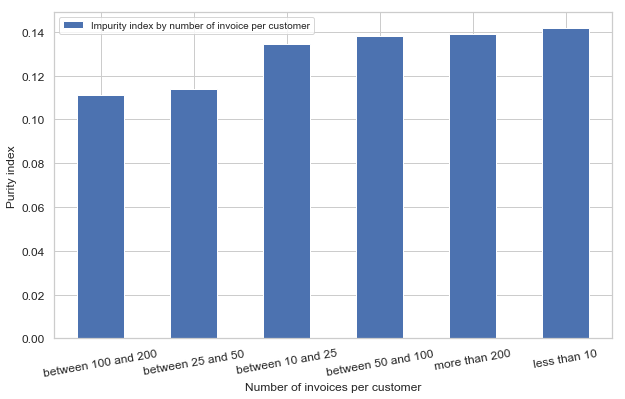

In [34]:
final_df.groupby('cnt_invoice')['impurity_index2'].mean().sort_values().plot(kind = 'bar',figsize=(10,6), 
                                                            label = 'Impurity index by number of invoice per customer')
plt.xticks(rotation = 10)
plt.legend(loc="upper left", fontsize = 'medium')
plt.xlabel('Number of invoices per customer', fontsize = 'large')
plt.ylabel('Purity index', fontsize = 'large')
plt.xticks(fontsize = 'large')
plt.yticks(fontsize = 'large')
plt.show()

Below stacked bar chart is created to see variation in payment status over fiscal periods. A lot of variation can be observed among the 3 payment status over entire period.

Text(0,0.5,'Number of Invoice')

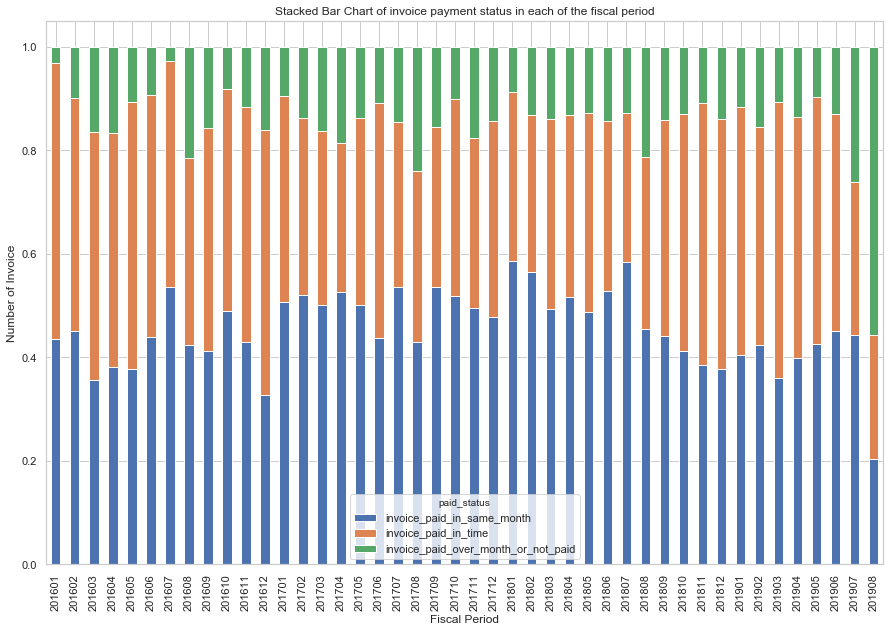

In [35]:
#exploring relationship between Logged in status against signup source
table=pd.crosstab(inv_data['Fiscal_Period'],inv_data['paid_status'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', figsize=(15,10), stacked=True)
plt.title('Stacked Bar Chart of invoice payment status in each of the fiscal period')
plt.xlabel('Fiscal Period')
plt.ylabel('Number of Invoice')

### Modelling

##### Approach

I will be exploring supervised technique to help predict whether a customer will pay the invoice or outstanding balance by the next due date based on the actions generated by the company and the customer's response history. We will be consider behavioural scoring based on 3 labels: 

1. In time payment behavior 
2. In month payment behavior
3. Delayed over month behavior

I will starting to explore simpler algorithms like decision tree and logistic regression to see if we can get a good results using those and then gradually increase complexity with more sophisticated modeling algorithms like random forest, xgboost or neural netwrok.

Features has been created based on available data as this data cannot be directly utilized for providing input features to model.

Feature Engineering steps include but not limited to

* handling missing value
* binning of a numeric feature
* deriving features from existing raw features
* Data aggregation and combining

In [36]:
inv_data['Invoice_Due_Date'].dt.year.unique()

array([2015, 2016, 2017, 2018, 2019, 2014, 2013, 2012], dtype=int64)

##### Preparation of Training & Test Data

In [37]:
model_data = inv_data[['Customer_ID','Fiscal_Period','Country_ID','Invoice_Creation_Date','Invoice_Due_Date','Invoice_amount',
                       'invoice_due_in_days','invoice_paid_in_days','delay_in_days','cnt_dispute_PO','dispute_PO_amt',
                       'paid_status']]
model_data = model_data[model_data['Invoice_Due_Date'] <= '2019-01-31']
train_data = model_data[model_data['Invoice_Due_Date'] <= '2018-08-31']
test_data = model_data[~(model_data['Invoice_Due_Date'].isin(train_data['Invoice_Due_Date']))]
print(model_data.shape)
print(train_data.shape)
print(test_data.shape)

(404394, 12)
(353410, 12)
(50984, 12)


In [38]:
#extracting up to last 5 invoices  for each customer to create features related to recent payment behavior
other_df = train_data.sort_values(by = ['Customer_ID', 'Invoice_Due_Date'], ascending = False).groupby('Customer_ID').head(5)
print(other_df.shape)

(4700, 12)


Below created dataframe is meant to capture recent behavior of customer by capturing data up to last 5 invoices

In [39]:
other_df2 = other_df[other_df['paid_status'] == 'invoice_paid_in_time'].groupby('Customer_ID')['paid_status'].count()/other_df.groupby('Customer_ID')['paid_status'].count()
other_df2 = other_df2.reset_index()
other_df2 = other_df2.rename(columns = {'paid_status': 'rec_pct_of_paid_invoices_in_time'})
other_df2['rec_pct_of_paid_invoices_in_time'].fillna(0,inplace = True)
other_df3 = other_df.groupby('Customer_ID')['Invoice_amount'].mean().reset_index()
other_df3 = other_df3.rename(columns = {'Invoice_amount': 'rec_average_invoice_amount'})
other_df4 = other_df.groupby('Customer_ID')['invoice_paid_in_days'].mean().reset_index()
other_df4 = other_df4.rename(columns = {'invoice_paid_in_days': 'rec_average_invoice_paid_in_days'})
other_df5 = other_df[other_df['paid_status'] != 'invoice_paid_in_time'].groupby('Customer_ID')['delay_in_days'].mean().reset_index()
other_df5 = other_df5.rename(columns = {'delay_in_days': 'rec_average_delay_in_days'})

#merging all
df_list1 = [other_df2,other_df3,other_df4,other_df5]
final_df_rec = reduce(lambda left,right: pd.merge(left,right,how = 'outer',on='Customer_ID'), df_list1)
final_df_rec.fillna(0, inplace=True)
final_df_rec.head()

,Customer_ID,rec_pct_of_paid_invoices_in_time,rec_average_invoice_amount,rec_average_invoice_paid_in_days,rec_average_delay_in_days
0,10112,1.0,3644.570,41.0,0.0
1,10114,1.0,4603.194,42.0,0.0
2,10117,0.8,39084.744,42.6,1.0
3,10118,1.0,31362.786,42.4,0.0
4,10121,1.0,19464.304,49.8,0.0


In [40]:
#calculate historical variables - training data
final_df_hist = train_data.groupby(['Customer_ID','Country_ID'])[['Invoice_amount','invoice_due_in_days',
                                                                  'invoice_paid_in_days','delay_in_days',
                                                                  'cnt_dispute_PO','dispute_PO_amt']].mean().reset_index()
final_df_hist.head()

,Customer_ID,Country_ID,Invoice_amount,invoice_due_in_days,invoice_paid_in_days,delay_in_days,cnt_dispute_PO,dispute_PO_amt
0,10112,77,3644.570000,44.000000,41.000000,0.000000,3.0,1353.333333
1,10114,77,4485.283105,36.279113,36.532348,1.147874,27.0,977.556296
2,10117,77,29290.798353,42.806015,48.097744,9.309023,88.0,414.632841
3,10118,77,49786.655693,36.006397,43.036247,7.059701,7.0,8996.235714
4,10121,77,37537.897875,41.272356,40.970645,2.134137,158.0,5537.083671


In [41]:
final_df.head()

,Customer_ID,cnt_invoice_paid_in_time,cnt_invoice_paid_in_same_month,cnt_invoice_paid_over_month_or_not_paid,num_invoice,cnt_invoice,impurity_index1,impurity_index2
0,10112,1.0,0.0,0.0,1.0,less than 10,0.000000,0.000000
1,10114,514.0,102.0,26.0,642.0,more than 200,0.199377,0.040498
2,10117,663.0,627.0,154.0,1444.0,more than 200,0.540859,0.106648
3,10118,154.0,290.0,106.0,550.0,more than 200,0.720000,0.192727
4,10121,5481.0,235.0,318.0,6034.0,more than 200,0.091647,0.052701


In [42]:
df_list2 = [final_df_hist, final_df_rec,final_df]
train_feats = reduce(lambda left,right: pd.merge(left, right, how = 'inner',on='Customer_ID'), df_list2)

In [43]:
train_data = pd.merge(train_data, train_feats, how = 'outer',on = ['Customer_ID','Country_ID'])
print(train_data.shape)

(353410, 29)


In [44]:
#remove vars calculated over entire dataset
train_data.drop(['Invoice_amount_x','invoice_due_in_days_x','invoice_paid_in_days_x','delay_in_days_x',
                 'cnt_dispute_PO_x','dispute_PO_amt_x'],1,inplace = True)

In [45]:
train_data = train_data.rename(columns = {'Invoice_amount_y':'avg_invoice_amount','invoice_due_in_days_y':'avg_due_in_days',
                  'invoice_paid_in_days_y':'avg_invoice_paid_in_days','delay_in_days_y':'avg_delay_in_days',
                                          'cnt_dispute_PO_y':'cnt_dispute_PO','dispute_PO_amt_y':'dispute_PO_amt'})

In [46]:
#converting target variable to numeric code
train_data['target'] = np.where(train_data['paid_status'] == 'invoice_paid_in_time',0,
                               np.where(train_data['paid_status'] == 'invoice_paid_in_same_month',1,2))

In [47]:
#Handling Categorical Feature - convert catgoeical features to dummy vars using 1 hot encoding
cat_vars = ['Country_ID','cnt_invoice']

for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(train_data[var], prefix=var)
    df1=train_data.join(cat_list)
    train_data=df1
    
data_vars=df1.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [48]:
train_data['cnt_dispute_PO'].fillna(0, inplace = True)
train_data['dispute_PO_amt'].fillna(0, inplace = True)

In [49]:
print(train_data.shape)

(353410, 33)


###### Processing test data

In [50]:
#extracting up to last 5 invoices  for each customer to create features related to recent payment behavior for test data
other_df = test_data.sort_values(by = ['Customer_ID', 'Fiscal_Period'], ascending = False).groupby('Customer_ID').head(5)
print(other_df.shape)
other_df2 = other_df[other_df['paid_status'] == 'invoice_paid_in_time'].groupby('Customer_ID')['paid_status'].count()/other_df.groupby('Customer_ID')['paid_status'].count()
other_df2 = other_df2.reset_index()
other_df2 = other_df2.rename(columns = {'paid_status': 'rec_pct_of_paid_invoices_in_time'})
other_df2['rec_pct_of_paid_invoices_in_time'].fillna(np.mean(other_df2['rec_pct_of_paid_invoices_in_time']),inplace = True)
other_df3 = other_df.groupby('Customer_ID')['Invoice_amount'].mean().reset_index()
other_df3 = other_df3.rename(columns = {'Invoice_amount': 'rec_average_invoice_amount'})
other_df4 = other_df.groupby('Customer_ID')['invoice_paid_in_days'].mean().reset_index()
other_df4 = other_df4.rename(columns = {'invoice_paid_in_days': 'rec_average_invoice_paid_in_days'})
other_df5 = other_df[other_df['paid_status'] != 'invoice_paid_in_time'].groupby('Customer_ID')['delay_in_days'].mean().reset_index()
other_df5 = other_df5.rename(columns = {'delay_in_days': 'rec_average_delay_in_days'})

#merging all
df_list1 = [other_df2,other_df3,other_df4,other_df5]
final_df_rec_test = reduce(lambda left,right: pd.merge(left,right,how = 'outer',on='Customer_ID'), df_list1)
final_df_rec_test.fillna(0, inplace=True)
final_df_rec_test.head()

(3642, 12)


,Customer_ID,rec_pct_of_paid_invoices_in_time,rec_average_invoice_amount,rec_average_invoice_paid_in_days,rec_average_delay_in_days
0,10114,1.000000,3787.050,42.4,0.0
1,10117,0.692481,41973.252,55.6,12.6
2,10118,0.692481,55202.750,49.2,3.0
3,10121,0.800000,73679.718,55.8,5.0
4,10128,1.000000,17187.956,31.6,0.0


In [51]:
#calculate historical variables - training data
final_df_hist_test = test_data.groupby(['Customer_ID','Country_ID'])[['Invoice_amount','invoice_due_in_days',
                                                                  'invoice_paid_in_days','delay_in_days',
                                                                     'cnt_dispute_PO','dispute_PO_amt']].mean().reset_index()
final_df_hist_test.head()

,Customer_ID,Country_ID,Invoice_amount,invoice_due_in_days,invoice_paid_in_days,delay_in_days,cnt_dispute_PO,dispute_PO_amt
0,10114,77,3142.642090,36.880597,35.298507,0.000000,27.0,977.556296
1,10117,77,45289.204851,43.000000,46.455446,6.128713,88.0,414.632841
2,10118,77,49604.773793,36.603448,40.517241,3.913793,7.0,8996.235714
3,10121,77,45166.970152,42.847793,42.476408,0.173516,158.0,5537.083671
4,10128,77,19048.935455,36.000000,31.818182,0.000000,3.0,228.580000


In [52]:
df_list3 = [final_df_hist_test, final_df_rec_test,final_df]
test_feats = reduce(lambda left,right: pd.merge(left, right, how = 'inner',on='Customer_ID'), df_list3)

In [53]:
test_data = pd.merge(test_data, test_feats, how = 'outer',on = ['Customer_ID','Country_ID'])
print(test_data.shape)

(50984, 29)


In [54]:
#remove vars calculated over entire dataset
test_data.drop(['Invoice_amount_x','invoice_due_in_days_x','invoice_paid_in_days_x','delay_in_days_x',
               'cnt_dispute_PO_x','dispute_PO_amt_x'],1,inplace = True)
test_data = test_data.rename(columns = {'Invoice_amount_y':'avg_invoice_amount','invoice_due_in_days_y':'avg_due_in_days',
                  'invoice_paid_in_days_y':'avg_invoice_paid_in_days','delay_in_days_y':'avg_delay_in_days',
                                       'cnt_dispute_PO_y':'cnt_dispute_PO','dispute_PO_amt_y':'dispute_PO_amt'})
print(test_data.shape)

(50984, 23)


In [55]:
#converting target variable to numeric code
test_data['target'] = np.where(test_data['paid_status'] == 'invoice_paid_in_time',0,
                               np.where(test_data['paid_status'] == 'invoice_paid_in_same_month',1,2))

In [56]:
#Handling Categorical Feature - convert catgoeical features to dummy vars using 1 hot encoding
cat_vars = ['Country_ID','cnt_invoice']

for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(test_data[var], prefix=var)
    df1=test_data.join(cat_list)
    test_data=df1
    
data_vars=df1.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [57]:
test_data['cnt_dispute_PO'].fillna(0, inplace = True)
test_data['dispute_PO_amt'].fillna(0, inplace = True)

In [58]:
print(test_data.shape)

(50984, 33)


##### Fitting Model

In [59]:
from sklearn.base import clone
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [60]:
selvars = ['avg_invoice_amount','avg_due_in_days','avg_invoice_paid_in_days','avg_delay_in_days','cnt_dispute_PO',
           'dispute_PO_amt','rec_pct_of_paid_invoices_in_time','rec_average_invoice_amount','rec_average_invoice_paid_in_days',
           'rec_average_delay_in_days','cnt_invoice_paid_in_time','cnt_invoice_paid_in_same_month',
           'cnt_invoice_paid_over_month_or_not_paid','num_invoice','impurity_index1','impurity_index2',
           'Country_ID_66','Country_ID_77','Country_ID_83','cnt_invoice_between 10 and 25','cnt_invoice_between 100 and 200',
           'cnt_invoice_between 25 and 50','cnt_invoice_between 50 and 100','cnt_invoice_less than 10',
           'cnt_invoice_more than 200']

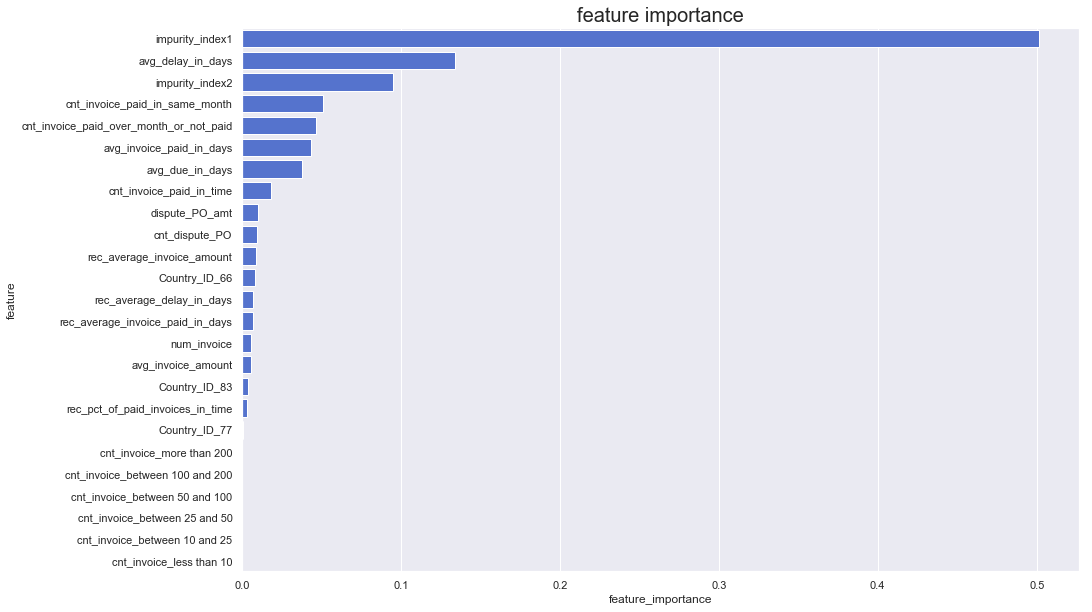

In [67]:
sns.set(rc = {'figure.figsize':(15, 10)})
from sklearn.base import clone

# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}).sort_values('feature_importance', 
                                                                       ascending = False).reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', 
                color = 'royalblue').set_title(title, fontsize = 20)
    
rf_model = RandomForestClassifier().fit(train_data[selvars], train_data['target'])

var_imp = imp_df(train_data[selvars].columns, rf_model.feature_importances_)
var_imp_plot(var_imp, 'feature importance')

In [61]:
selvars1 = ['impurity_index1','avg_delay_in_days','cnt_invoice_paid_in_same_month','impurity_index2',
            'cnt_invoice_paid_in_time','avg_invoice_paid_in_days','cnt_invoice_paid_over_month_or_not_paid',
            'rec_pct_of_paid_invoices_in_time','avg_due_in_days','cnt_dispute_PO','rec_average_invoice_amount',
            'dispute_PO_amt']

In [71]:
#create an array of models
models = []
models.append(("RF",RandomForestClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("BRF",BalancedRandomForestClassifier()))
models.append(("KNN",KNeighborsClassifier()))

#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=5, random_state=22)
    cv_result = cross_val_score(model, train_data[selvars1], train_data['target'], cv = kfold,scoring = "accuracy")
    print(name, cv_result)

RF [0.71384511 0.67049602 0.70841233 0.64266716 0.65180668]
XGB [0.7168869  0.6716703  0.70892165 0.64562406 0.65551343]
BRF [0.70152231 0.65619252 0.67588636 0.42423814 0.62701961]
KNN [0.45697632 0.49810418 0.50949322 0.37583826 0.39947936]


##### Random Forest

In [59]:
#apply grid search for best set of hyper parameters
%timeit

rf = RandomForestClassifier(class_weight={0:1/42.01,1:1/45.37,2:1/12.62})
rf_params = {'n_estimators': [100, 200,400,500,700], 'max_depth': [3,5,7,11,15],
            'min_samples_split': [5, 10,20,30,40]}
rf_grid = GridSearchCV(rf, rf_params, cv = 5, verbose=10, n_jobs = -1, scoring='accuracy')
rf_grid.fit(train_data[selvars1], train_data['target'])
print(rf_grid.best_params_)
print(rf_grid.cv_results_)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 24.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 33

{'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 200}
{'mean_fit_time': array([ 10.9674778 ,  21.62119484,  43.56412463,  55.09309883,
        77.27504392,  11.25032158,  22.10350447,  44.01133313,
        54.89304061,  76.87556701,  11.224191  ,  22.26667323,
        43.94868784,  54.01150517,  75.50054936,  10.98872194,
        21.73269587,  43.66676054,  54.19769783,  75.61842837,
        10.9734622 ,  21.82305422,  43.4221725 ,  54.18395724,
        75.4642406 ,  13.81346984,  27.58245611,  55.20944128,
        67.86378689,  94.11370707,  13.60702114,  27.20275083,
        53.95774016,  67.31283121,  93.96249423,  13.7393765 ,
        27.01518555,  53.72935524,  67.48758297,  94.11018829,
        13.67025228,  26.89668908,  53.55911813,  66.72141585,
        94.29908395,  13.78853617,  26.85101271,  53.49278226,
        66.86243777,  92.99042211,  15.59610281,  30.91055856,
        61.48260713,  76.9498754 , 107.65178752,  15.54569969,
        30.93800764,  61.35390983,  7

In [62]:
rf_model = RandomForestClassifier(n_estimators=300, max_depth = 8, min_samples_split=10, 
                                  class_weight={0:1/0.42,1:1/0.45,2:1/0.13}, n_jobs=-1, 
                                  random_state = 42).fit(train_data[selvars1], train_data['target'])

print('Accuracy of Random Forest classifier on training set: {:.2f}'
       .format(rf_model.score(train_data[selvars1], train_data['target'])*100))
print('Accuracy of Random Forest classifier on test set: {:.2f}'
       .format(rf_model.score(test_data[selvars1], test_data['target'])*100))

Accuracy of Random Forest classifier on training set: 62.25
Accuracy of Random Forest classifier on test set: 58.46


In [63]:
y_true = np.array(test_data['target'])
y_pred = rf_model.predict(test_data[selvars1])

In [64]:
confusion_matrix(y_true, y_pred)

array([[15023,  4575,  3010],
       [ 5498, 11486,  5562],
       [ 1204,  1331,  3295]], dtype=int64)

In [65]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.66      0.68     22608
           1       0.66      0.51      0.58     22546
           2       0.28      0.57      0.37      5830

    accuracy                           0.58     50984
   macro avg       0.54      0.58      0.54     50984
weighted avg       0.63      0.58      0.60     50984



##### XGBoost

In [122]:
xgb_model = xgb.XGBClassifier(max_depth=8, n_estimators=300, class_weight={0:1/0.42,1:1/0.45,2:1/0.13},
                              learning_rate=0.001).fit(train_data[selvars1], train_data['target'])

y_pred = xgb_model.predict(test_data[selvars1])

print('Accuracy of XGBoost classifier on training set: {:.2f}'
       .format(xgb_model.score(train_data[selvars1], train_data['target'])*100))
print('Accuracy of XGBoost classifier on test set: {:.2f}'
       .format(xgb_model.score(test_data[selvars1], test_data['target'])*100))

Accuracy of XGBoost classifier on training set: 68.74
Accuracy of XGBoost classifier on test set: 64.45


In [123]:
confusion_matrix(y_true, y_pred)

array([[14525,  7033,  1050],
       [ 4646, 16746,  1154],
       [ 1366,  2878,  1586]], dtype=int64)

In [124]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.64      0.67     22608
           1       0.63      0.74      0.68     22546
           2       0.42      0.27      0.33      5830

    accuracy                           0.64     50984
   macro avg       0.58      0.55      0.56     50984
weighted avg       0.64      0.64      0.64     50984



##### ANN

In [80]:
#creating arrays out of train/test dataframes
X_train, y_train = train_data[selvars1].values, np.array(train_data['target']).reshape(-1,1)
X_test, y_test = test_data[selvars1].values, np.array(test_data['target']).reshape(-1,1)
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

#normalizing features
#scaling data using MinMaxScalar
scaler_X_train = MinMaxScaler()
print(scaler_X_train.fit(X_train))
X_train = scaler_X_train.transform(X_train)

scaler_X_test = MinMaxScaler()
print(scaler_X_test.fit(X_test))
X_test = scaler_X_test.transform(X_test)

MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


In [81]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 0.8436519019825497, 1: 0.7123535624732925, 2: 2.433802312528838}

W0304 11:57:21.660197 12952 deprecation.py:506] From C:\Users\Manoj\Anaconda3\lib\site-packages\tensorflow\python\keras\initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0304 11:57:21.708071 12952 deprecation.py:506] From C:\Users\Manoj\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                650       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                465       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 4

282728/282728 [==============================] - 6s 22us/sample - loss: 0.8167 - acc: 0.6084 - val_loss: 0.8540 - val_acc: 0.6237
Epoch 50/150
282728/282728 [==============================] - 6s 22us/sample - loss: 0.8164 - acc: 0.6089 - val_loss: 0.8531 - val_acc: 0.6264
Epoch 51/150
282728/282728 [==============================] - 6s 22us/sample - loss: 0.8168 - acc: 0.6093 - val_loss: 0.8555 - val_acc: 0.6355
Epoch 52/150
282728/282728 [==============================] - 6s 22us/sample - loss: 0.8169 - acc: 0.6090 - val_loss: 0.8486 - val_acc: 0.6231
Epoch 53/150
282728/282728 [==============================] - 6s 23us/sample - loss: 0.8162 - acc: 0.6075 - val_loss: 0.8556 - val_acc: 0.6331
Epoch 54/150
282728/282728 [==============================] - 6s 22us/sample - loss: 0.8173 - acc: 0.6092 - val_loss: 0.8527 - val_acc: 0.6298
Epoch 55/150
282728/282728 [==============================] - 6s 22us/sample - loss: 0.8176 - acc: 0.6084 - val_loss: 0.8503 - val_acc: 0.6222
Epoch 56/150

282728/282728 [==============================] - 6s 22us/sample - loss: 0.8158 - acc: 0.6114 - val_loss: 0.8572 - val_acc: 0.6239
Epoch 107/150
282728/282728 [==============================] - 6s 22us/sample - loss: 0.8158 - acc: 0.6118 - val_loss: 0.8525 - val_acc: 0.6274
Epoch 108/150
282728/282728 [==============================] - 7s 23us/sample - loss: 0.8152 - acc: 0.6099 - val_loss: 0.8497 - val_acc: 0.6267
Epoch 109/150
282728/282728 [==============================] - 7s 23us/sample - loss: 0.8161 - acc: 0.6102 - val_loss: 0.8504 - val_acc: 0.6297
Epoch 110/150
282728/282728 [==============================] - 6s 23us/sample - loss: 0.8158 - acc: 0.6110 - val_loss: 0.8515 - val_acc: 0.6289
Epoch 111/150
282728/282728 [==============================] - 6s 22us/sample - loss: 0.8158 - acc: 0.6115 - val_loss: 0.8509 - val_acc: 0.6273
Epoch 112/150
282728/282728 [==============================] - 6s 22us/sample - loss: 0.8155 - acc: 0.6128 - val_loss: 0.8503 - val_acc: 0.6270
Epoch 

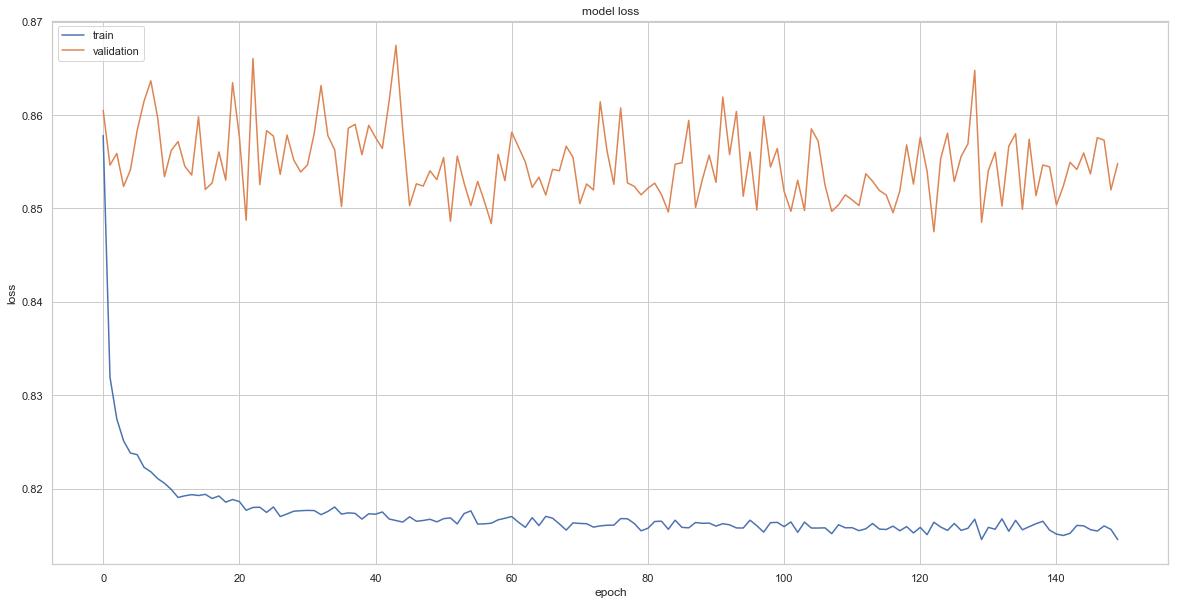

In [82]:
#building model architecture using Kera Sequential API
model = Sequential()

model.add(Dense(50, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(15, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=150, batch_size=100,  verbose=1, validation_split=0.2, 
                    class_weight = d_class_weights)

#plotting training and validation loss during traing against number of epochs
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [83]:
#accuracy score for training/test set
print('Accuracy of ANN classifier on training set: {:.2f}'
       .format(model.evaluate(X_train, y_train, verbose = 0)[1]*100))
print('Accuracy of ANN classifier on test set: {:.2f}'
       .format(model.evaluate(X_test, y_test, verbose = 0)[1]*100))

Accuracy of ANN classifier on training set: 61.95
Accuracy of ANN classifier on test set: 54.83


In [84]:
#prediction on test data
y_pred = (model.predict(X_test) >= 0.5).astype(int)

#confusion matrix
#from sklearn.metrics import confusion_matrix
#print(confusion_matrix(y_test, y_pred))

In [85]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.57      0.64     22608
           1       0.67      0.31      0.42     22546
           2       0.26      0.57      0.36      5830

   micro avg       0.57      0.46      0.51     50984
   macro avg       0.55      0.48      0.47     50984
weighted avg       0.65      0.46      0.51     50984
 samples avg       0.46      0.46      0.46     50984



#### Data Preparation For Validation Set

In [66]:
val_data = inv_data[~(inv_data['Invoice_Due_Date'].isin(model_data['Invoice_Due_Date']))]
print(val_data.shape)

(16160, 15)


In [67]:
#extracting up to last 5 invoices  for each customer to create features related to recent payment behavior for test data
other_df = val_data.sort_values(by = ['Customer_ID', 'Fiscal_Period'], ascending = False).groupby('Customer_ID').head(5)
print(other_df.shape)
other_df2 = other_df[other_df['paid_status'] == 'invoice_paid_in_time'].groupby('Customer_ID')['paid_status'].count()/other_df.groupby('Customer_ID')['paid_status'].count()
other_df2 = other_df2.reset_index()
other_df2 = other_df2.rename(columns = {'paid_status': 'rec_pct_of_paid_invoices_in_time'})
other_df2['rec_pct_of_paid_invoices_in_time'].fillna(np.mean(other_df2['rec_pct_of_paid_invoices_in_time']),inplace = True)
other_df3 = other_df.groupby('Customer_ID')['Invoice_amount'].mean().reset_index()
other_df3 = other_df3.rename(columns = {'Invoice_amount': 'rec_average_invoice_amount'})
other_df4 = other_df.groupby('Customer_ID')['invoice_paid_in_days'].mean().reset_index()
other_df4 = other_df4.rename(columns = {'invoice_paid_in_days': 'rec_average_invoice_paid_in_days'})
other_df5 = other_df[other_df['paid_status'] != 'invoice_paid_in_time'].groupby('Customer_ID')['delay_in_days'].mean().reset_index()
other_df5 = other_df5.rename(columns = {'delay_in_days': 'rec_average_delay_in_days'})

#merging all
df_list1 = [other_df2,other_df3,other_df4,other_df5]
final_df_rec_val = reduce(lambda left,right: pd.merge(left,right,how = 'outer',on='Customer_ID'), df_list1)
final_df_rec_val.fillna(0, inplace=True)
final_df_rec_val.head()

(2812, 15)


,Customer_ID,rec_pct_of_paid_invoices_in_time,rec_average_invoice_amount,rec_average_invoice_paid_in_days,rec_average_delay_in_days
0,10114,1.000000,1648.848,44.4,0.0
1,10117,0.200000,66608.774,47.4,8.5
2,10118,0.619095,54195.510,46.4,1.0
3,10121,1.000000,23229.128,56.4,0.0
4,10128,0.600000,22251.956,33.4,0.0


In [68]:
#calculate historical variables - training data
final_df_hist_val = val_data.groupby(['Customer_ID','Country_ID'])[['Invoice_amount','invoice_due_in_days',
                                                                  'invoice_paid_in_days','delay_in_days',
                                                                     'cnt_dispute_PO','dispute_PO_amt']].mean().reset_index()
final_df_hist_val.head()

,Customer_ID,Country_ID,Invoice_amount,invoice_due_in_days,invoice_paid_in_days,delay_in_days,cnt_dispute_PO,dispute_PO_amt
0,10114,77,1898.780000,33.294118,32.823529,0.000000,27.0,977.556296
1,10117,77,47056.892308,43.000000,43.846154,2.615385,88.0,414.632841
2,10118,77,56821.320435,36.782609,37.217391,0.434783,7.0,8996.235714
3,10121,77,41316.575665,40.515021,39.836910,0.000000,158.0,5537.083671
4,10128,77,20286.776667,36.000000,33.833333,0.000000,3.0,228.580000


In [70]:
df_list4 = [final_df_hist_val, final_df_rec_val,final_df]
val_feats = reduce(lambda left,right: pd.merge(left, right, how = 'inner',on='Customer_ID'), df_list4)

In [71]:
val_data = pd.merge(val_data, val_feats, how = 'outer',on = ['Customer_ID','Country_ID'])
print(val_data.shape)

(16160, 32)


In [72]:
#remove vars calculated over entire dataset
val_data.drop(['Invoice_amount_x','invoice_due_in_days_x','invoice_paid_in_days_x','delay_in_days_x',
               'cnt_dispute_PO_x','dispute_PO_amt_x'],1,inplace = True)
val_data = val_data.rename(columns = {'Invoice_amount_y':'avg_invoice_amount','invoice_due_in_days_y':'avg_due_in_days',
                  'invoice_paid_in_days_y':'avg_invoice_paid_in_days','delay_in_days_y':'avg_delay_in_days',
                                       'cnt_dispute_PO_y':'cnt_dispute_PO','dispute_PO_amt_y':'dispute_PO_amt'})
print(val_data.shape)

(16160, 26)


In [73]:
#converting target variable to numeric code
val_data['target'] = np.where(val_data['paid_status'] == 'invoice_paid_in_time',0,
                               np.where(val_data['paid_status'] == 'invoice_paid_in_same_month',1,2))

In [74]:
#Handling Categorical Feature - convert catgoeical features to dummy vars using 1 hot encoding
cat_vars = ['Country_ID','cnt_invoice']

for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(val_data[var], prefix=var)
    df1=val_data.join(cat_list)
    val_data=df1
    
data_vars=df1.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [75]:
val_data['cnt_dispute_PO'].fillna(0, inplace = True)
val_data['dispute_PO_amt'].fillna(0, inplace = True)
print(val_data.shape)

(16160, 36)


In [112]:
val_data['target'].value_counts()

2    9167
0    4108
1    2885
Name: target, dtype: int64

In [110]:
#scoring using RF model
val_pred = rf_model.predict(val_data[selvars1])
print(confusion_matrix(val_data['target'],val_pred))
print(classification_report(val_data['target'],val_pred))

[[3082  535  491]
 [ 724 1940  221]
 [3769 3386 2012]]
              precision    recall  f1-score   support

           0       0.41      0.75      0.53      4108
           1       0.33      0.67      0.44      2885
           2       0.74      0.22      0.34      9167

    accuracy                           0.44     16160
   macro avg       0.49      0.55      0.44     16160
weighted avg       0.58      0.44      0.41     16160



In [111]:
#scoring using ANN model
val_pred1 = model.predict_classes(val_data[selvars1])
print(confusion_matrix(val_data['target'],val_pred1))
print(classification_report(val_data['target'],val_pred1))

[[ 332 3774    2]
 [  26 2847   12]
 [ 215 8947    5]]
              precision    recall  f1-score   support

           0       0.58      0.08      0.14      4108
           1       0.18      0.99      0.31      2885
           2       0.26      0.00      0.00      9167

    accuracy                           0.20     16160
   macro avg       0.34      0.36      0.15     16160
weighted avg       0.33      0.20      0.09     16160

